# Seq2Seq Approach for generating Mega Millions Numbers  
forked from: https://www.kaggle.com/code/gogo827jz/lotto-prediction/notebook

model theory:
https://towardsdatascience.com/day-1-2-attention-seq2seq-models-65df3f49e263

experiment for free:
https://colab.research.google.com/

In [21]:
import gc
import os
import math
import numpy as np
import pandas as pd
from numba import njit
from numpy import sqrt, sin, cos, pi, zeros
from numpy.random import randn, rand, uniform, normal
from scipy.linalg import hadamard
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, LSTM, Dropout, RepeatVector, TimeDistributed, Embedding, Reshape, Dot, Concatenate
from tensorflow.keras.layers import GRU, SpatialDropout1D, Conv1D, GlobalMaxPooling1D,Multiply, Lambda, Softmax, Flatten, BatchNormalization, Bidirectional, dot, concatenate
from tensorflow.keras.layers import AdditiveAttention, Attention
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.9.2


# Configurations

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.71.194.66:8470


REPLICAS:  8


In [3]:
MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Accelerated Linear Algebra enabled


# Mount Google Drive, Get the Dataset


In [4]:
import pandas as pd
from google.colab import drive, files
import numpy as np

drive.mount('/content/drive/')
output_directory = "/content/drive/My Drive/"
lotto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LottoPredictions/data/mm-newrulesfwdcutoff.csv', index_col = 'Date')
lotto = lotto.drop(['BB'], axis = 1)
print(lotto)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
            B1  B2  B3  B4  B5  B6
Date                              
1/10/2023    7  13  14  15  18   9
1/6/2023     3  20  46  59  63  13
1/3/2023    25  29  33  41  44  18
12/30/2022   1   3   6  44  51   7
12/27/2022   9  13  36  59  61  11
...         ..  ..  ..  ..  ..  ..
11/7/2017    1  54  60  68  69  11
11/3/2017   10  22  42  61  69   3
10/31/2017   6  28  31  52  53  12
10/27/2017  17  27  41  51  52  13
10/24/2017  20  24  34  56  64   6

[545 rows x 6 columns]


# Train Test Split
Use the last 50 draws as the test dataset
Use a sliding window of 10 to split the input data

In [5]:
#infer training epocs from len of dataframe:

data = lotto.values - 1

#tf.keras.utils.normalize(data)
assert not np.any(np.isnan(data))

train = data[:-50]
test = data[-50:]

w = 10
X_train = []
y_train = []
for i in range(w, len(train)):
    X_train.append(train[i - w: i, :])
    y_train.append(train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

inputs = data[data.shape[0] - test.shape[0] - w:]
X_test = []
for i in range(w, inputs.shape[0]):
    X_test.append(inputs[i - w: i, :])
X_test = np.array(X_test)
y_test = test

In [6]:
print('<nans>')
assert not np.any(np.isnan(X_train))
assert not np.any(np.isnan(y_train))
print ('</nans>')
print(data.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

<nans>
</nans>
(545, 6)
(485, 10, 6)
(485, 6)
(50, 10, 6)
(50, 6)


# Seq2Seq Model to Predict Future Draws

Input the last 10 draws and sequentially predict the next draw.
Monitor the performance by sparse categorical crossentropy and sparse top k categorical accuracy.

In [7]:
src_parameters = 6

#70 because mega millions white balls cap at 70
embed_dim = (70 // 2) + 1
dropout_rate = 0.5
spatial_dropout_rate = 0.5
steps_before = w
steps_after = src_parameters
feature_count = embed_dim * src_parameters
hidden_neurons = [64, 32] 
bidirectional = True
attention_style = 'Bahdanau' # or 'Luong'
#ref: https://machinelearningmastery.com/the-bahdanau-attention-mechanism/ or https://arxiv.org/pdf/1508.04025.pdf section 3.1 for differences

In [8]:
with strategy.scope():
    
    inp0 = Input(shape = (w, X_train.shape[2]))
    
    # Embed 70 categories into a 35-dimension continuous-number vector for each ball
    # largest value and largest value /2

    #these will be used to auto label instead of the manual zero hot encoding
    inp1 = Lambda(lambda x: x[:, :, 0])(inp0)
    inp1 = Embedding(70, embed_dim)(inp1)
    inp1 = SpatialDropout1D(spatial_dropout_rate)(inp1)
    
    inp2 = Lambda(lambda x: x[:, :, 1])(inp0)
    inp2 = Embedding(70, embed_dim)(inp2)
    inp2 = SpatialDropout1D(spatial_dropout_rate)(inp2)
    
    inp3 = Lambda(lambda x: x[:, :, 2])(inp0)
    inp3 = Embedding(70, embed_dim)(inp3)
    inp3 = SpatialDropout1D(spatial_dropout_rate)(inp3)

    inp4 = Lambda(lambda x: x[:, :, 3])(inp0)
    inp4 = Embedding(70, embed_dim)(inp4)
    inp4 = SpatialDropout1D(spatial_dropout_rate)(inp4)
    
    inp5 = Lambda(lambda x: x[:, :, 4])(inp0)
    inp5 = Embedding(70, embed_dim)(inp5)
    inp5 = SpatialDropout1D(spatial_dropout_rate)(inp5)

    #this one should actually be 25 but.. the last ball was actually pretty good.
    inp6 = Lambda(lambda x: x[:, :, 5])(inp0)
    inp6 = Embedding(70, embed_dim)(inp6)
    inp6 = SpatialDropout1D(spatial_dropout_rate)(inp6)


    inp = Concatenate()([inp1, inp2, inp3, inp4, inp5, inp6])
    
    # Seq2Seq model with attention or bidirectional encoder
    
    num_layers = len(hidden_neurons)
    
    sh_list, h_list, c_list = [inp], [], []
    
    if bidirectional:
        
        for i in range(num_layers):
    
            sh, fh, fc, bh, bc = Bidirectional(LSTM(hidden_neurons[i],
                                                    dropout = dropout_rate, 
                                                    return_state = True, 
                                                    return_sequences = True))(sh_list[-1])
        
            h = Concatenate()([fh, bh])
            c = Concatenate()([fc, bc]) 

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
        
    else:
    
        for i in range(num_layers):

            sh, h, c = LSTM(hidden_neurons[i], 
                            dropout = dropout_rate,
                            return_state = True, 
                            return_sequences = True)(sh_list[-1])

            sh_list.append(sh)
            h_list.append(h)
            c_list.append(c)
    
    decoder = RepeatVector(steps_after)(h_list[-1])
    
    if bidirectional:
        
        decoder_hidden_neurons = [hn * 2 for hn in hidden_neurons]
        
    else:
        
        decoder_hidden_neurons = hidden_neurons
    
    for i in range(num_layers):
        
        decoder = LSTM(decoder_hidden_neurons[i],
                       dropout = dropout_rate, 
                       return_sequences = True)(decoder, initial_state = [h_list[i], c_list[i]])
       
    if attention_style == 'Bahdanau':
        
        context = AdditiveAttention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
        
    elif attention_style == 'Luong':
        
        context = Attention(dropout = dropout_rate)([decoder, sh_list[-1]])
        
        decoder = concatenate([context, decoder])
    
    out = Dense(70, activation = 'softmax')(decoder)

    model = Model(inputs = inp0, outputs = out)
    
    sparse_top_k = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 5, name = 'sparse_top_k')
   
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = [sparse_top_k])
    #model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [sparse_top_k])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 6)]      0           []                               
                                                                                                  
 lambda (Lambda)                (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 10)           0           ['input_1[0][0]']                
                                                                                              

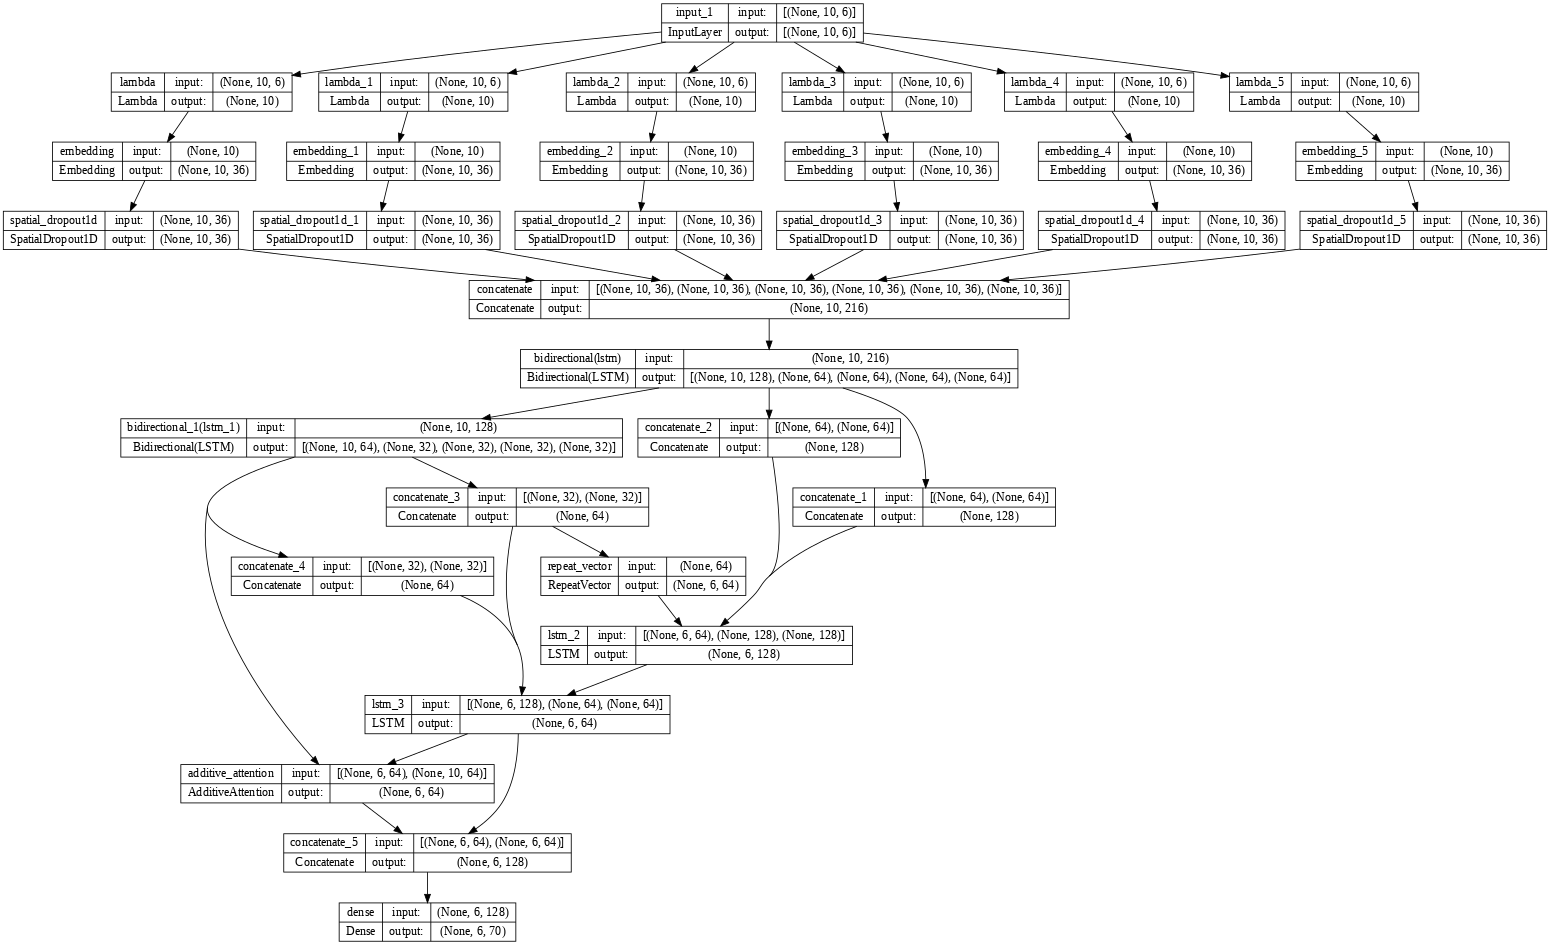

In [10]:
plot_model(model, show_shapes = True, show_layer_names = True, rankdir = 'TB', dpi = 60)

In [11]:
class CosAnnealer(callbacks.Callback):
    """Cosine annealing
    """

    def __init__(self, T_max, eta_max, eta_min = 0, verbose = 0):
        super(CosAnnealer, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs = None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        backend.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealer setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        logs['lr'] = backend.get_value(self.model.optimizer.lr)

In [12]:
training_basis = (len(lotto) /2)
EPOCHS = int(training_basis)
BATCH_SIZE = 32
LR_MAX = 1e-4
LR_MIN = 1e-5

cas = CosAnnealer(EPOCHS, LR_MAX, LR_MIN)

ckp = callbacks.ModelCheckpoint('model_candidate.hdf5', monitor = 'val_sparse_top_k', verbose = 0, 
                                save_best_only = True, save_weights_only = False, mode = 'max')

history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test), 
                    callbacks = [ckp, cas], 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2)

hist = pd.DataFrame(history.history)

Epoch 1/272
16/16 - 32s - loss: 4.2485 - sparse_top_k: 0.0777 - val_loss: 4.2472 - val_sparse_top_k: 0.1067 - lr: 1.0000e-04 - 32s/epoch - 2s/step
Epoch 2/272
16/16 - 1s - loss: 4.2474 - sparse_top_k: 0.0876 - val_loss: 4.2465 - val_sparse_top_k: 0.1167 - lr: 9.9997e-05 - 1s/epoch - 72ms/step
Epoch 3/272
16/16 - 1s - loss: 4.2464 - sparse_top_k: 0.0897 - val_loss: 4.2458 - val_sparse_top_k: 0.1133 - lr: 9.9988e-05 - 821ms/epoch - 51ms/step
Epoch 4/272
16/16 - 1s - loss: 4.2458 - sparse_top_k: 0.1031 - val_loss: 4.2449 - val_sparse_top_k: 0.1200 - lr: 9.9973e-05 - 1s/epoch - 73ms/step
Epoch 5/272
16/16 - 1s - loss: 4.2447 - sparse_top_k: 0.1017 - val_loss: 4.2439 - val_sparse_top_k: 0.1200 - lr: 9.9952e-05 - 828ms/epoch - 52ms/step
Epoch 6/272
16/16 - 1s - loss: 4.2430 - sparse_top_k: 0.1058 - val_loss: 4.2426 - val_sparse_top_k: 0.1133 - lr: 9.9925e-05 - 799ms/epoch - 50ms/step
Epoch 7/272
16/16 - 1s - loss: 4.2417 - sparse_top_k: 0.1065 - val_loss: 4.2410 - val_sparse_top_k: 0.1133 - 

0.2433333396911621


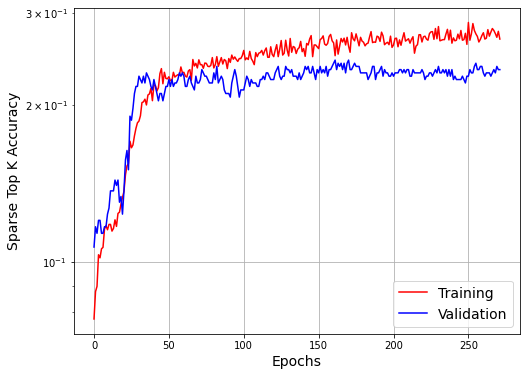

In [13]:
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

# Predict the Test Dataset

In [14]:
model.load_weights('model_candidate.hdf5')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

2/2 [==============================] - 5s 2s/step


In [15]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('Actual:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 4 14 31 44 64  4]
Actual:	 [ 8  9 32 42 59 10]
----------------------------------------
Prediction:	 [ 3 20 31 44 64  4]
Actual:	 [ 5 13 31 43 53 20]
----------------------------------------
Prediction:	 [ 3 20 31 44 64  4]
Actual:	 [16 33 51 54 67 20]
----------------------------------------
Prediction:	 [ 3 20 31 44 64  4]
Actual:	 [ 4 29 39 42 62 14]
----------------------------------------
Prediction:	 [ 3 14 31 44 64  4]
Actual:	 [11 28 31 46 59  1]
----------------------------------------
Prediction:	 [ 3 14 31 44 64  4]
Actual:	 [ 7 25 43 56 59 13]
----------------------------------------
Prediction:	 [ 4 14 31 44 64  4]
Actual:	 [ 4  8 23 53 59 17]
----------------------------------------
Prediction:	 [ 3 20 31 48 64 10]
Actual:	 [14 38 51 64 70  9]
----------------------------------------
Prediction:	 [ 3 14 31 44 64  4]
Actual:	 [ 1 13 26 33 52 11]
----------------------------------------
Prediction:	 [ 4 14 31 44 64  4]
Actual:	 [ 6 30 58 60 61 17]
-----------

# Predict the Future Draw on 2023-01-13

The Beam Search method will output 10 possible draws.  Though, they aren't very diverse in respect of your typical play card use case.

In [16]:
X_latest = X_test[-1][1:]
X_latest = np.concatenate([X_latest, y_test[-1].reshape(1, src_parameters)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[16 36 54 61 64 22]
  [ 3  7 22 27 50  3]
  [ 3 26 55 58 70 15]
  [ 1 14 21 22 28 19]
  [ 6 23 38 42 58 24]
  [ 1 54 60 68 69 11]
  [10 22 42 61 69  3]
  [ 6 28 31 52 53 12]
  [17 27 41 51 52 13]
  [20 24 34 56 64  6]]]


In [17]:
# beam search  ref: https://www.width.ai/post/what-is-beam-search
def do_beam_search(data, k, replace = True):
    sequences = [[list(), 0.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            best_k = np.argsort(row)[-k:]
            for j in best_k:
                candidate = [seq + [j], score + math.log(row[j])]
                if replace:
                    all_candidates.append(candidate)
                elif (replace == False) and (len(set(candidate[0])) == len(candidate[0])):
                    all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key = lambda tup:tup[1], reverse = True)
        # select k best
        sequences = ordered[:k]
    return sequences

In [18]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

1/1 [==============================] - 1s 1s/step
[ 3 24 31 48 70 10]


This would allow for duplicate balls, doesn't apply for Mega Millions

In [19]:
beam_width = 10
replace = True

result = do_beam_search(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 3 24 31 48 70 10] 	Log Likelihood:  -17.495828223795044
Prediction:  [ 3 20 31 48 70 10] 	Log Likelihood:  -17.515886194962256
Prediction:  [ 7 24 31 48 70 10] 	Log Likelihood:  -17.52215096851701
Prediction:  [ 3 24 31 48 70 11] 	Log Likelihood:  -17.525510820671776
Prediction:  [ 7 20 31 48 70 10] 	Log Likelihood:  -17.542208939684222
Prediction:  [ 3 20 31 48 70 11] 	Log Likelihood:  -17.54556879183899
Prediction:  [ 7 24 31 48 70 11] 	Log Likelihood:  -17.551833565393743
Prediction:  [ 3 24 31 48 70  4] 	Log Likelihood:  -17.55264097675404
Prediction:  [ 3 26 31 48 70 10] 	Log Likelihood:  -17.56332894965972
Prediction:  [ 7 20 31 48 70 11] 	Log Likelihood:  -17.571891536560955


This removes any duplicate balls on the same play, more realistic for Mega Millions

In [20]:
beam_width = 10
replace = False

result = do_beam_search(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 3 24 31 48 70 10] 	Log Likelihood:  -17.495828223795044
Prediction:  [ 3 20 31 48 70 10] 	Log Likelihood:  -17.515886194962256
Prediction:  [ 7 24 31 48 70 10] 	Log Likelihood:  -17.52215096851701
Prediction:  [ 3 24 31 48 70 11] 	Log Likelihood:  -17.525510820671776
Prediction:  [ 7 20 31 48 70 10] 	Log Likelihood:  -17.542208939684222
Prediction:  [ 3 20 31 48 70 11] 	Log Likelihood:  -17.54556879183899
Prediction:  [ 7 24 31 48 70 11] 	Log Likelihood:  -17.551833565393743
Prediction:  [ 3 24 31 48 70  4] 	Log Likelihood:  -17.55264097675404
Prediction:  [ 3 26 31 48 70 10] 	Log Likelihood:  -17.56332894965972
Prediction:  [ 7 20 31 48 70 11] 	Log Likelihood:  -17.571891536560955
